# CubiCasa / FloorplantoBlenderlib

In [ ]:
import os

#downloading weights 

!gdown 'https://drive.google.com/uc?id=1gRB7ez1e4H7a9Y09lLqRuna0luZO5VRK'

#downloading blender

blender_url =  "https://ftp.nluug.nl/pub/graphics/blender/release/Blender2.93/blender-2.93.1-linux-x64.tar.xz"
base_url = os.path.basename(blender_url)
!mkdir $blender_version
!wget -nc $blender_url
!tar -xkf $base_url -C ./$blender_version --strip-components=1
!rm blender-2.93.1-linux-x64.tar.xz

In [2]:
!pip install pyfiglet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.7 MB/s eta 0:00:00


In [9]:
!pip install lmdb

In [11]:
!pip install svgpathtools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [svgpathtools]


In [1]:
# Add outer folder 
 # Adds higher directory to python modules path.

# Import library
from utils.FloorplanToBlenderLib import *

# Other necessary libraries
import numpy as np

## Input Image
Now we need an example image to work with.

<div>
<img src="Images/fp_004.png" width="600"/>
</div>

# Detect Contours (Object Filter)

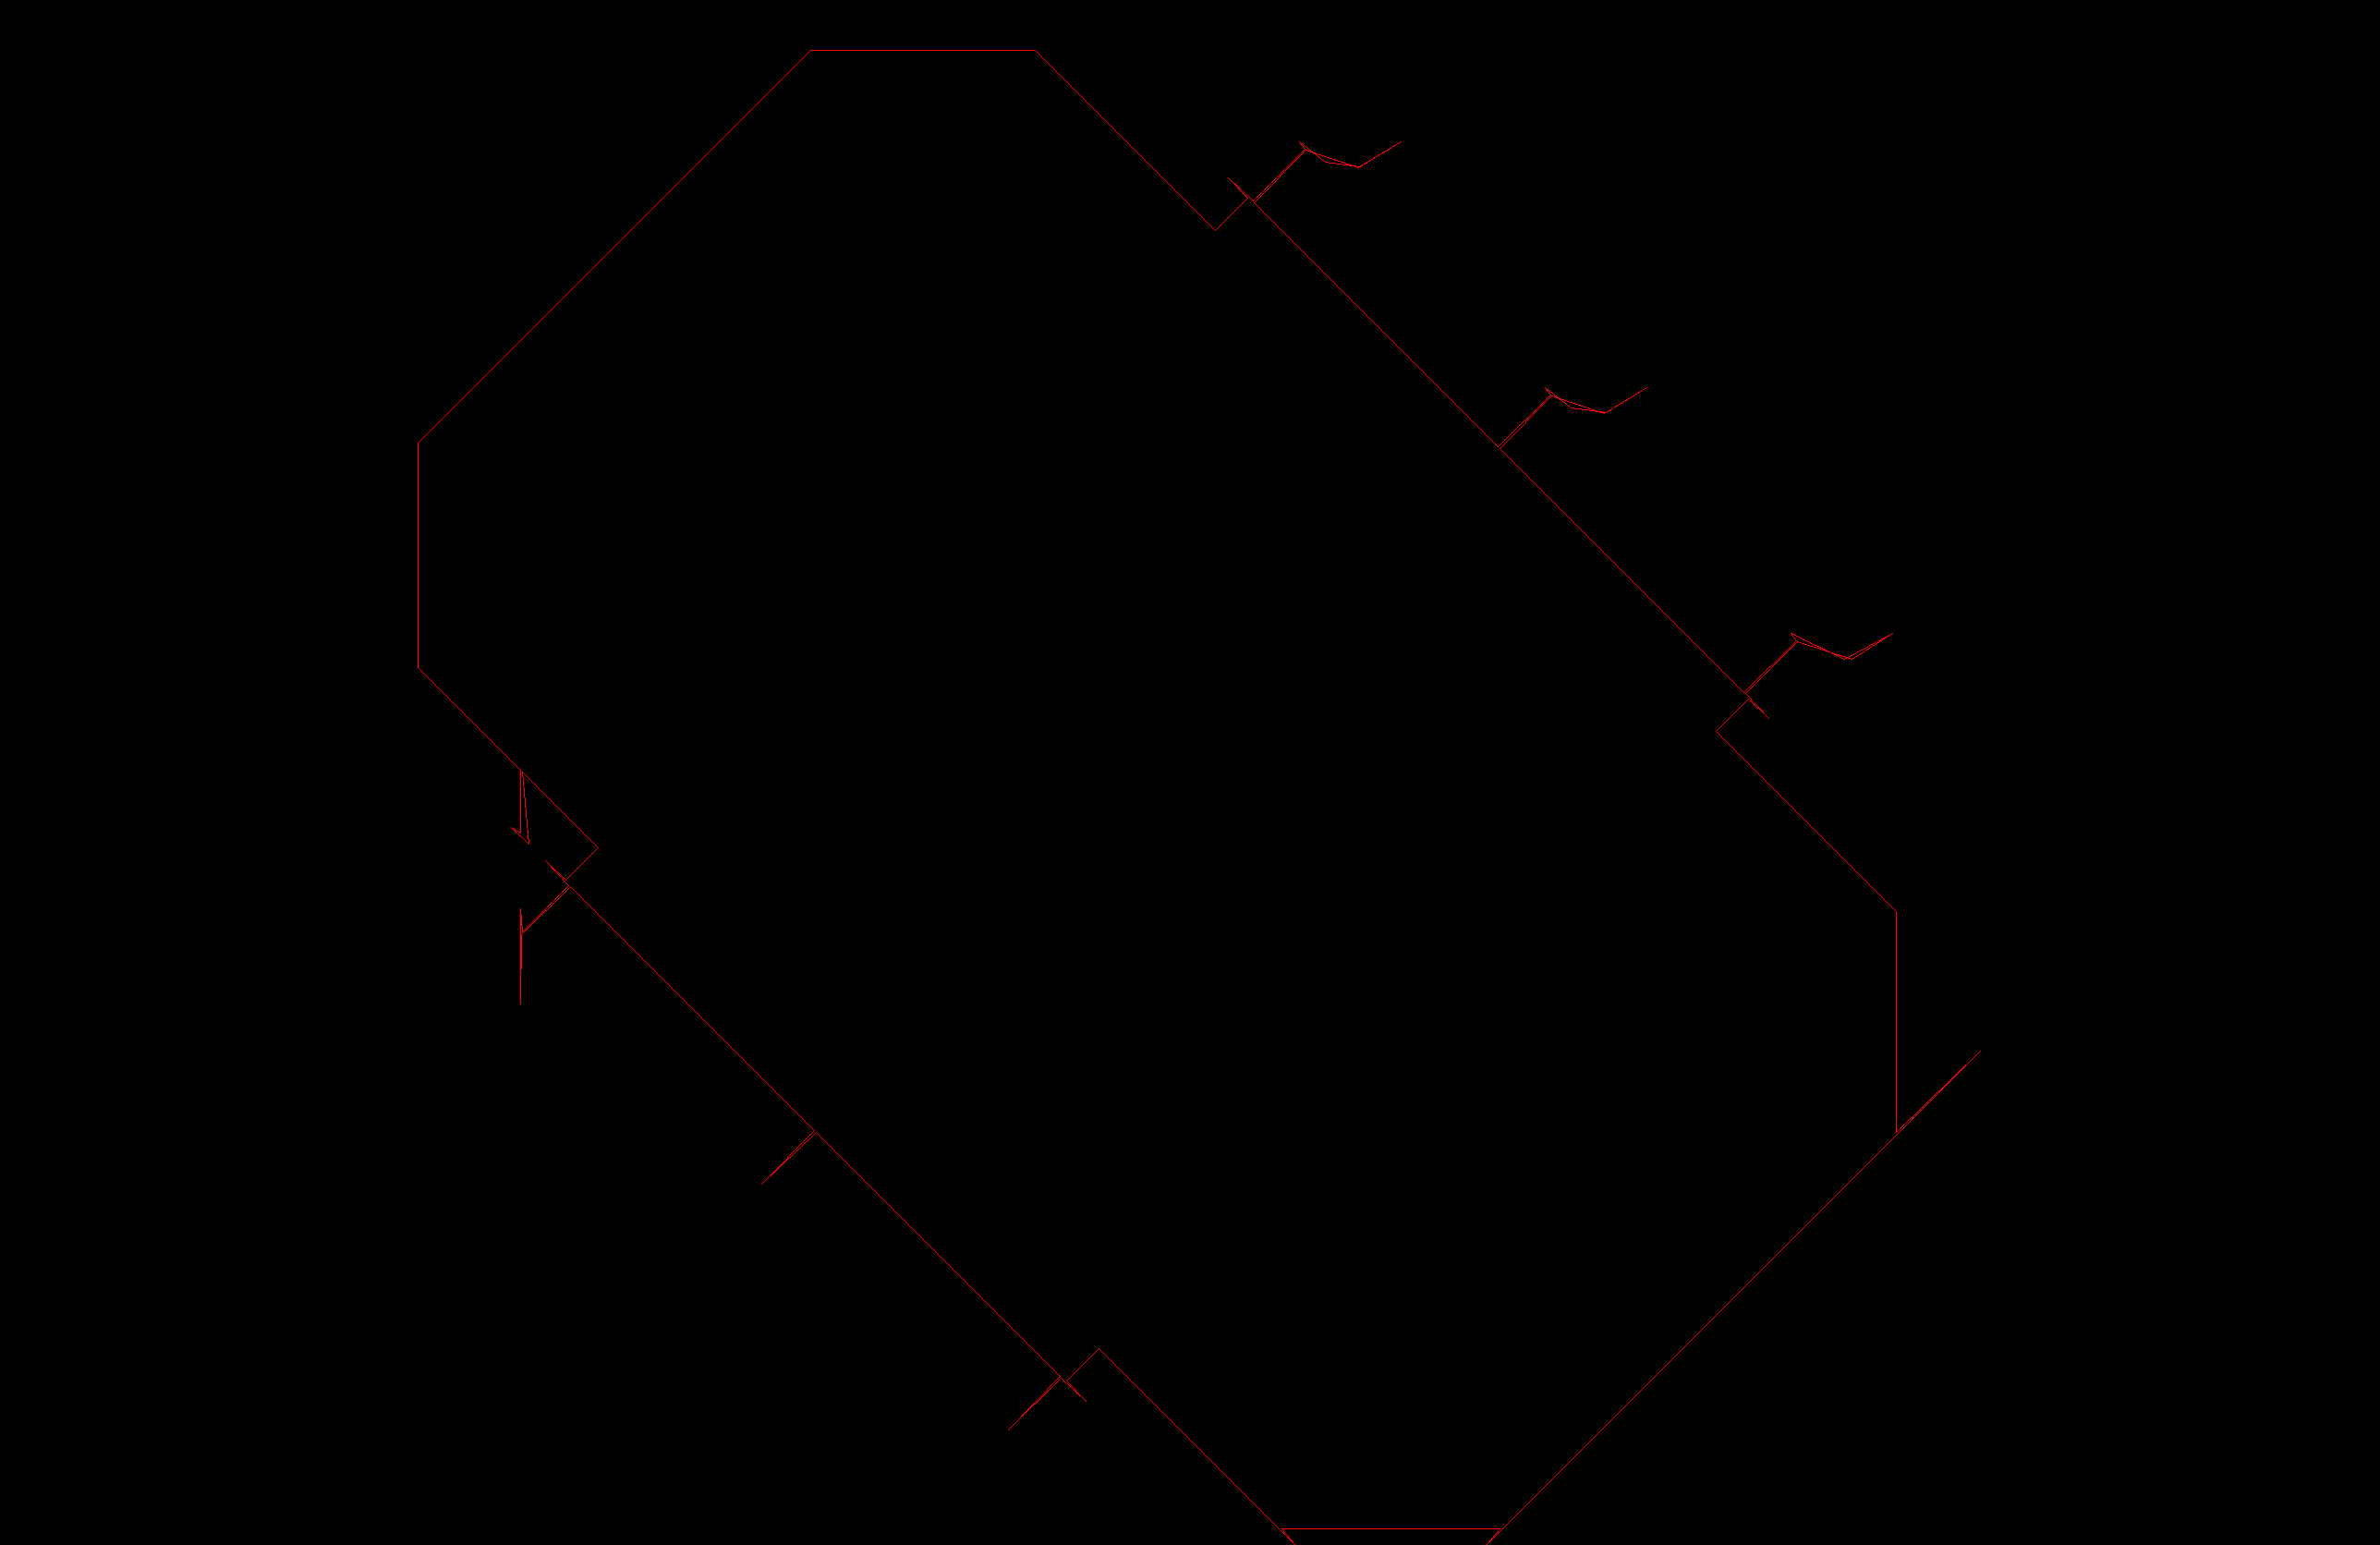

In [18]:
# Import library
from utils.FloorplanToBlenderLib import *

import cv2 # for image gathering
import numpy as np

# for visualize
from PIL import Image
from IPython.display import display

img_path = "Images/fp_004.png"

# Read floorplan image
img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = np.zeros((height,width,3), np.uint8)

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, img = detect.detectOuterContours(gray, blank_image, color=(255,0,0))

# Display
display(Image.fromarray(img))

# Detect Rooms (Object Filter)

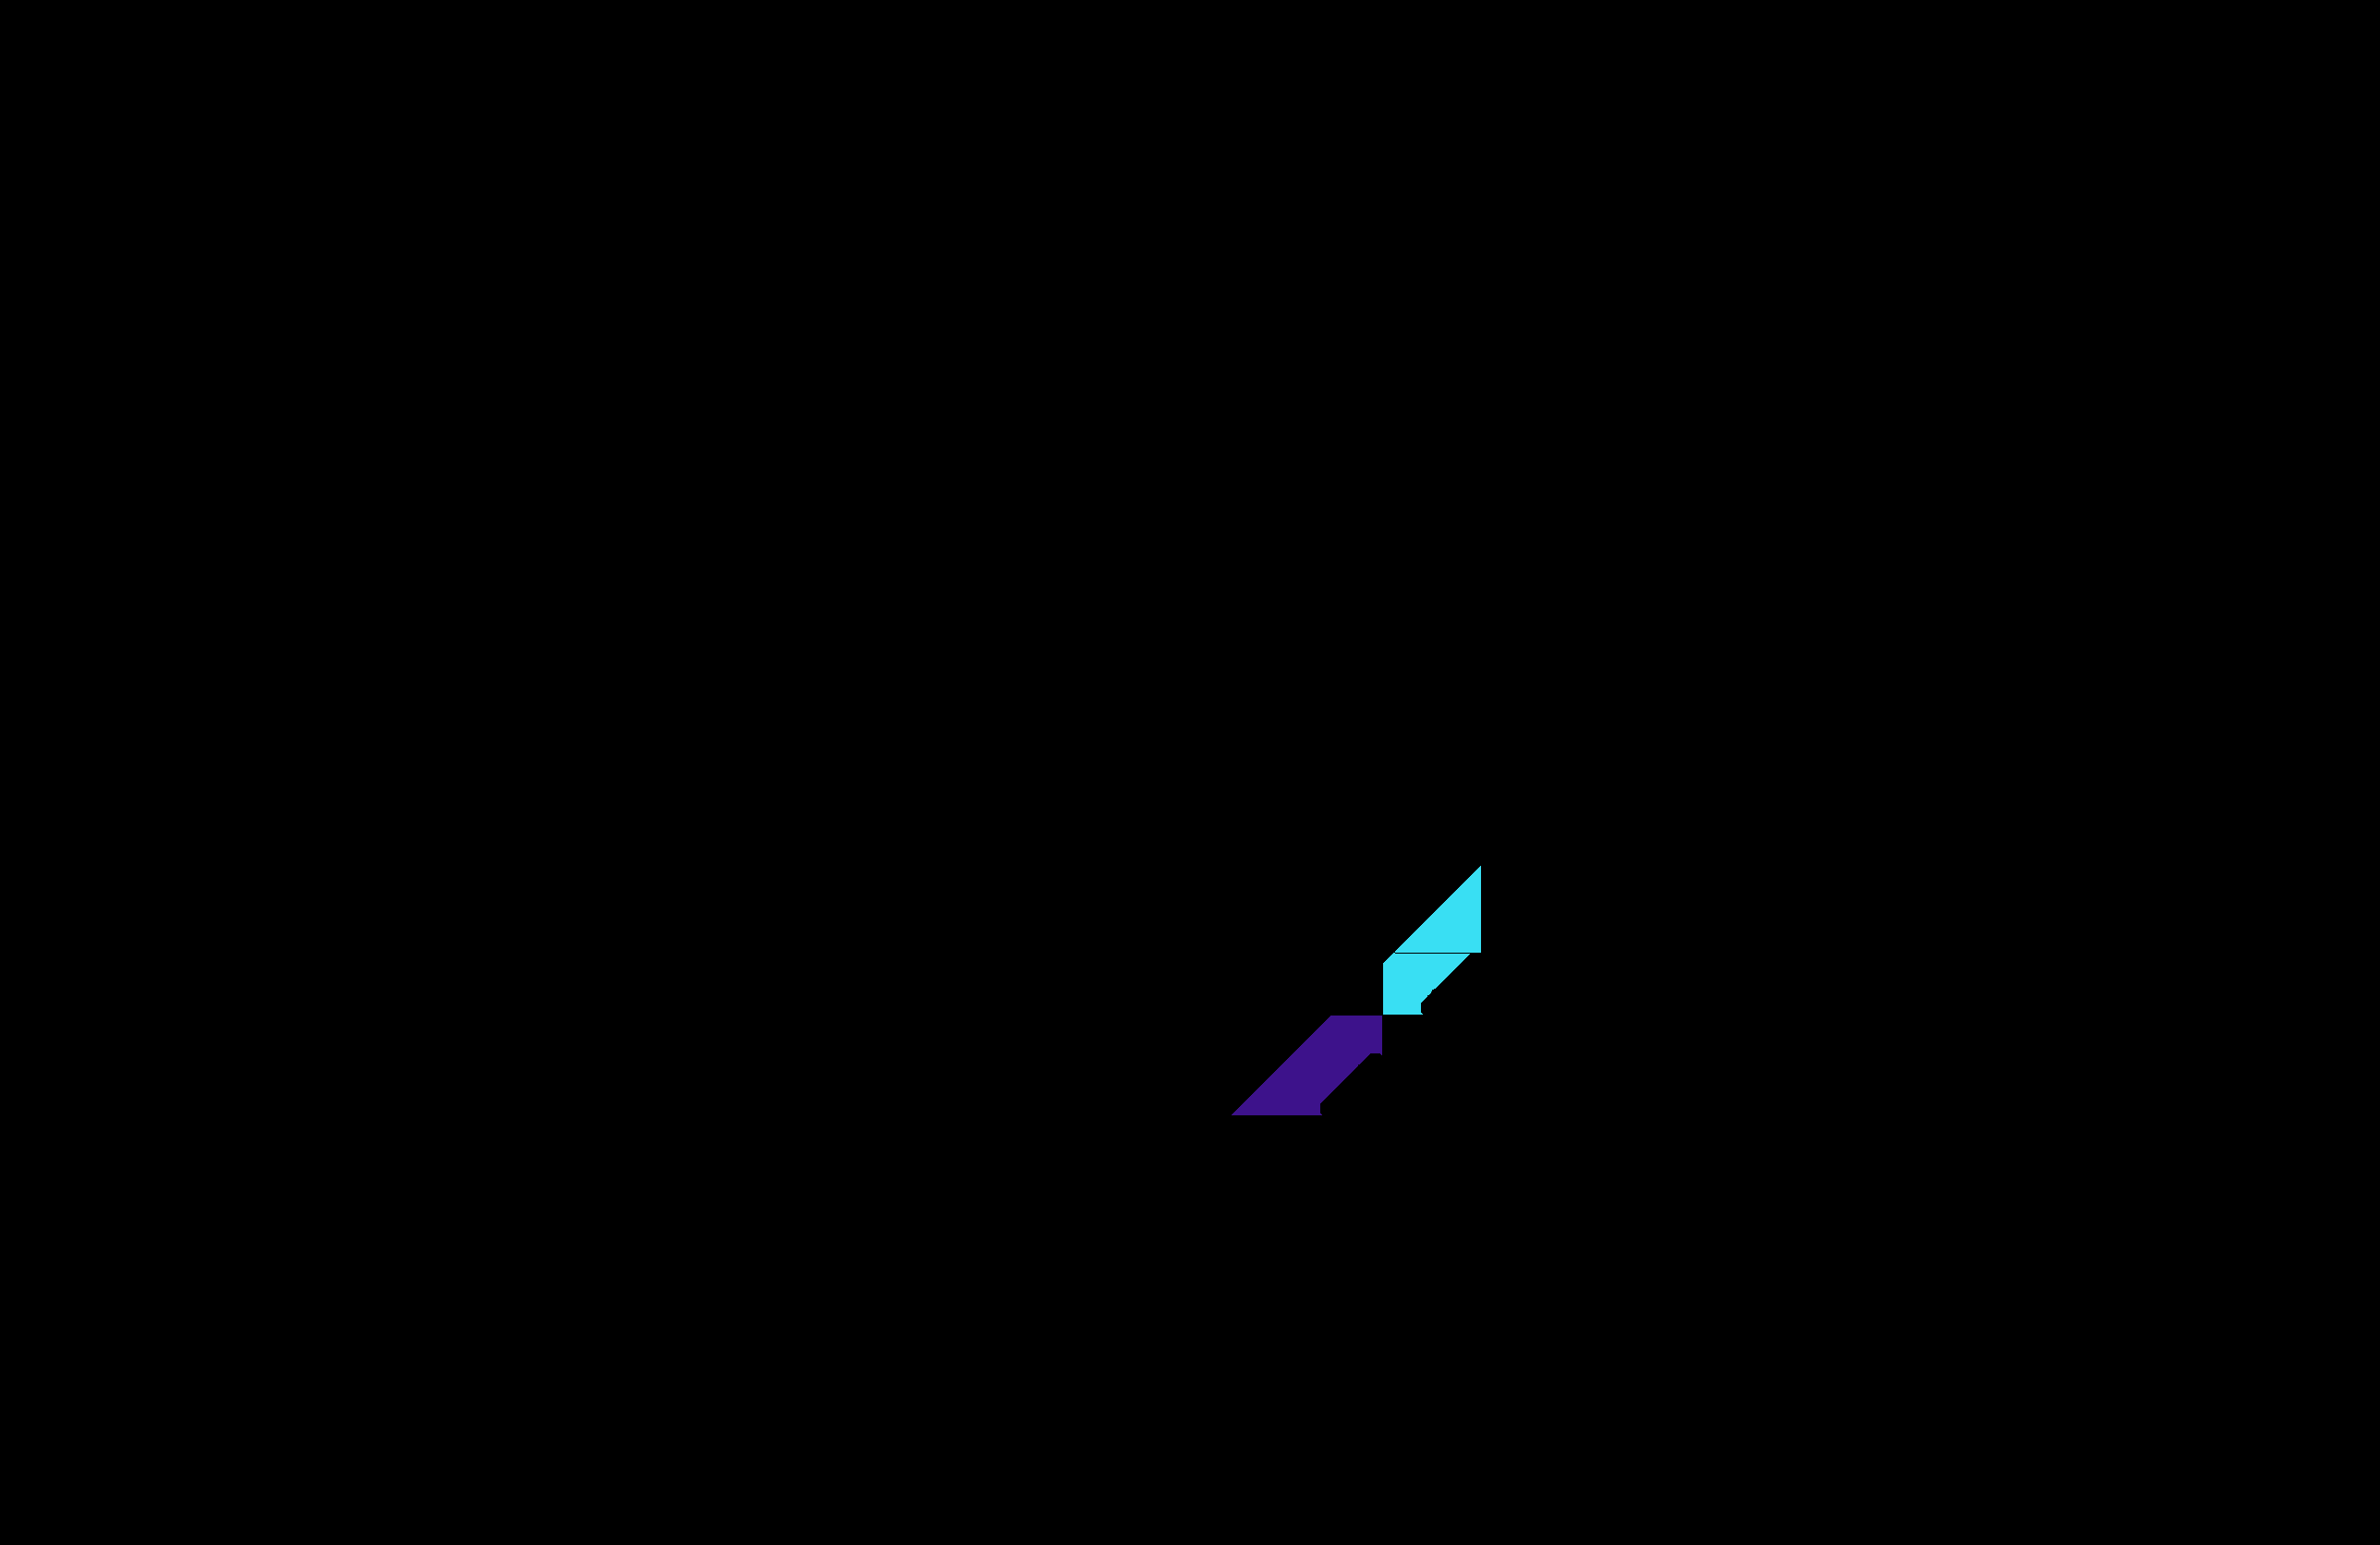

In [19]:
img = cv2.imread(img_path)

# grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
height = 0.999

# Scale pixel value to 3d pos
scale = 100

gray = detect.wall_filter(gray)

gray = ~gray

rooms, colored_rooms = detect.find_rooms(gray.copy())

gray_rooms =  cv2.cvtColor(colored_rooms,cv2.COLOR_BGR2GRAY)

# get box positions for rooms
boxes, gray_rooms = detect.detectPreciseBoxes(gray_rooms, gray_rooms)
display(Image.fromarray(colored_rooms))

 #Create verts
room_count = 0
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, height)])
    room_count+= 1

# create faces
for room in verts:
    count = 0
    temp = ()
    for pos in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

# Detect Walls (Object Filter)

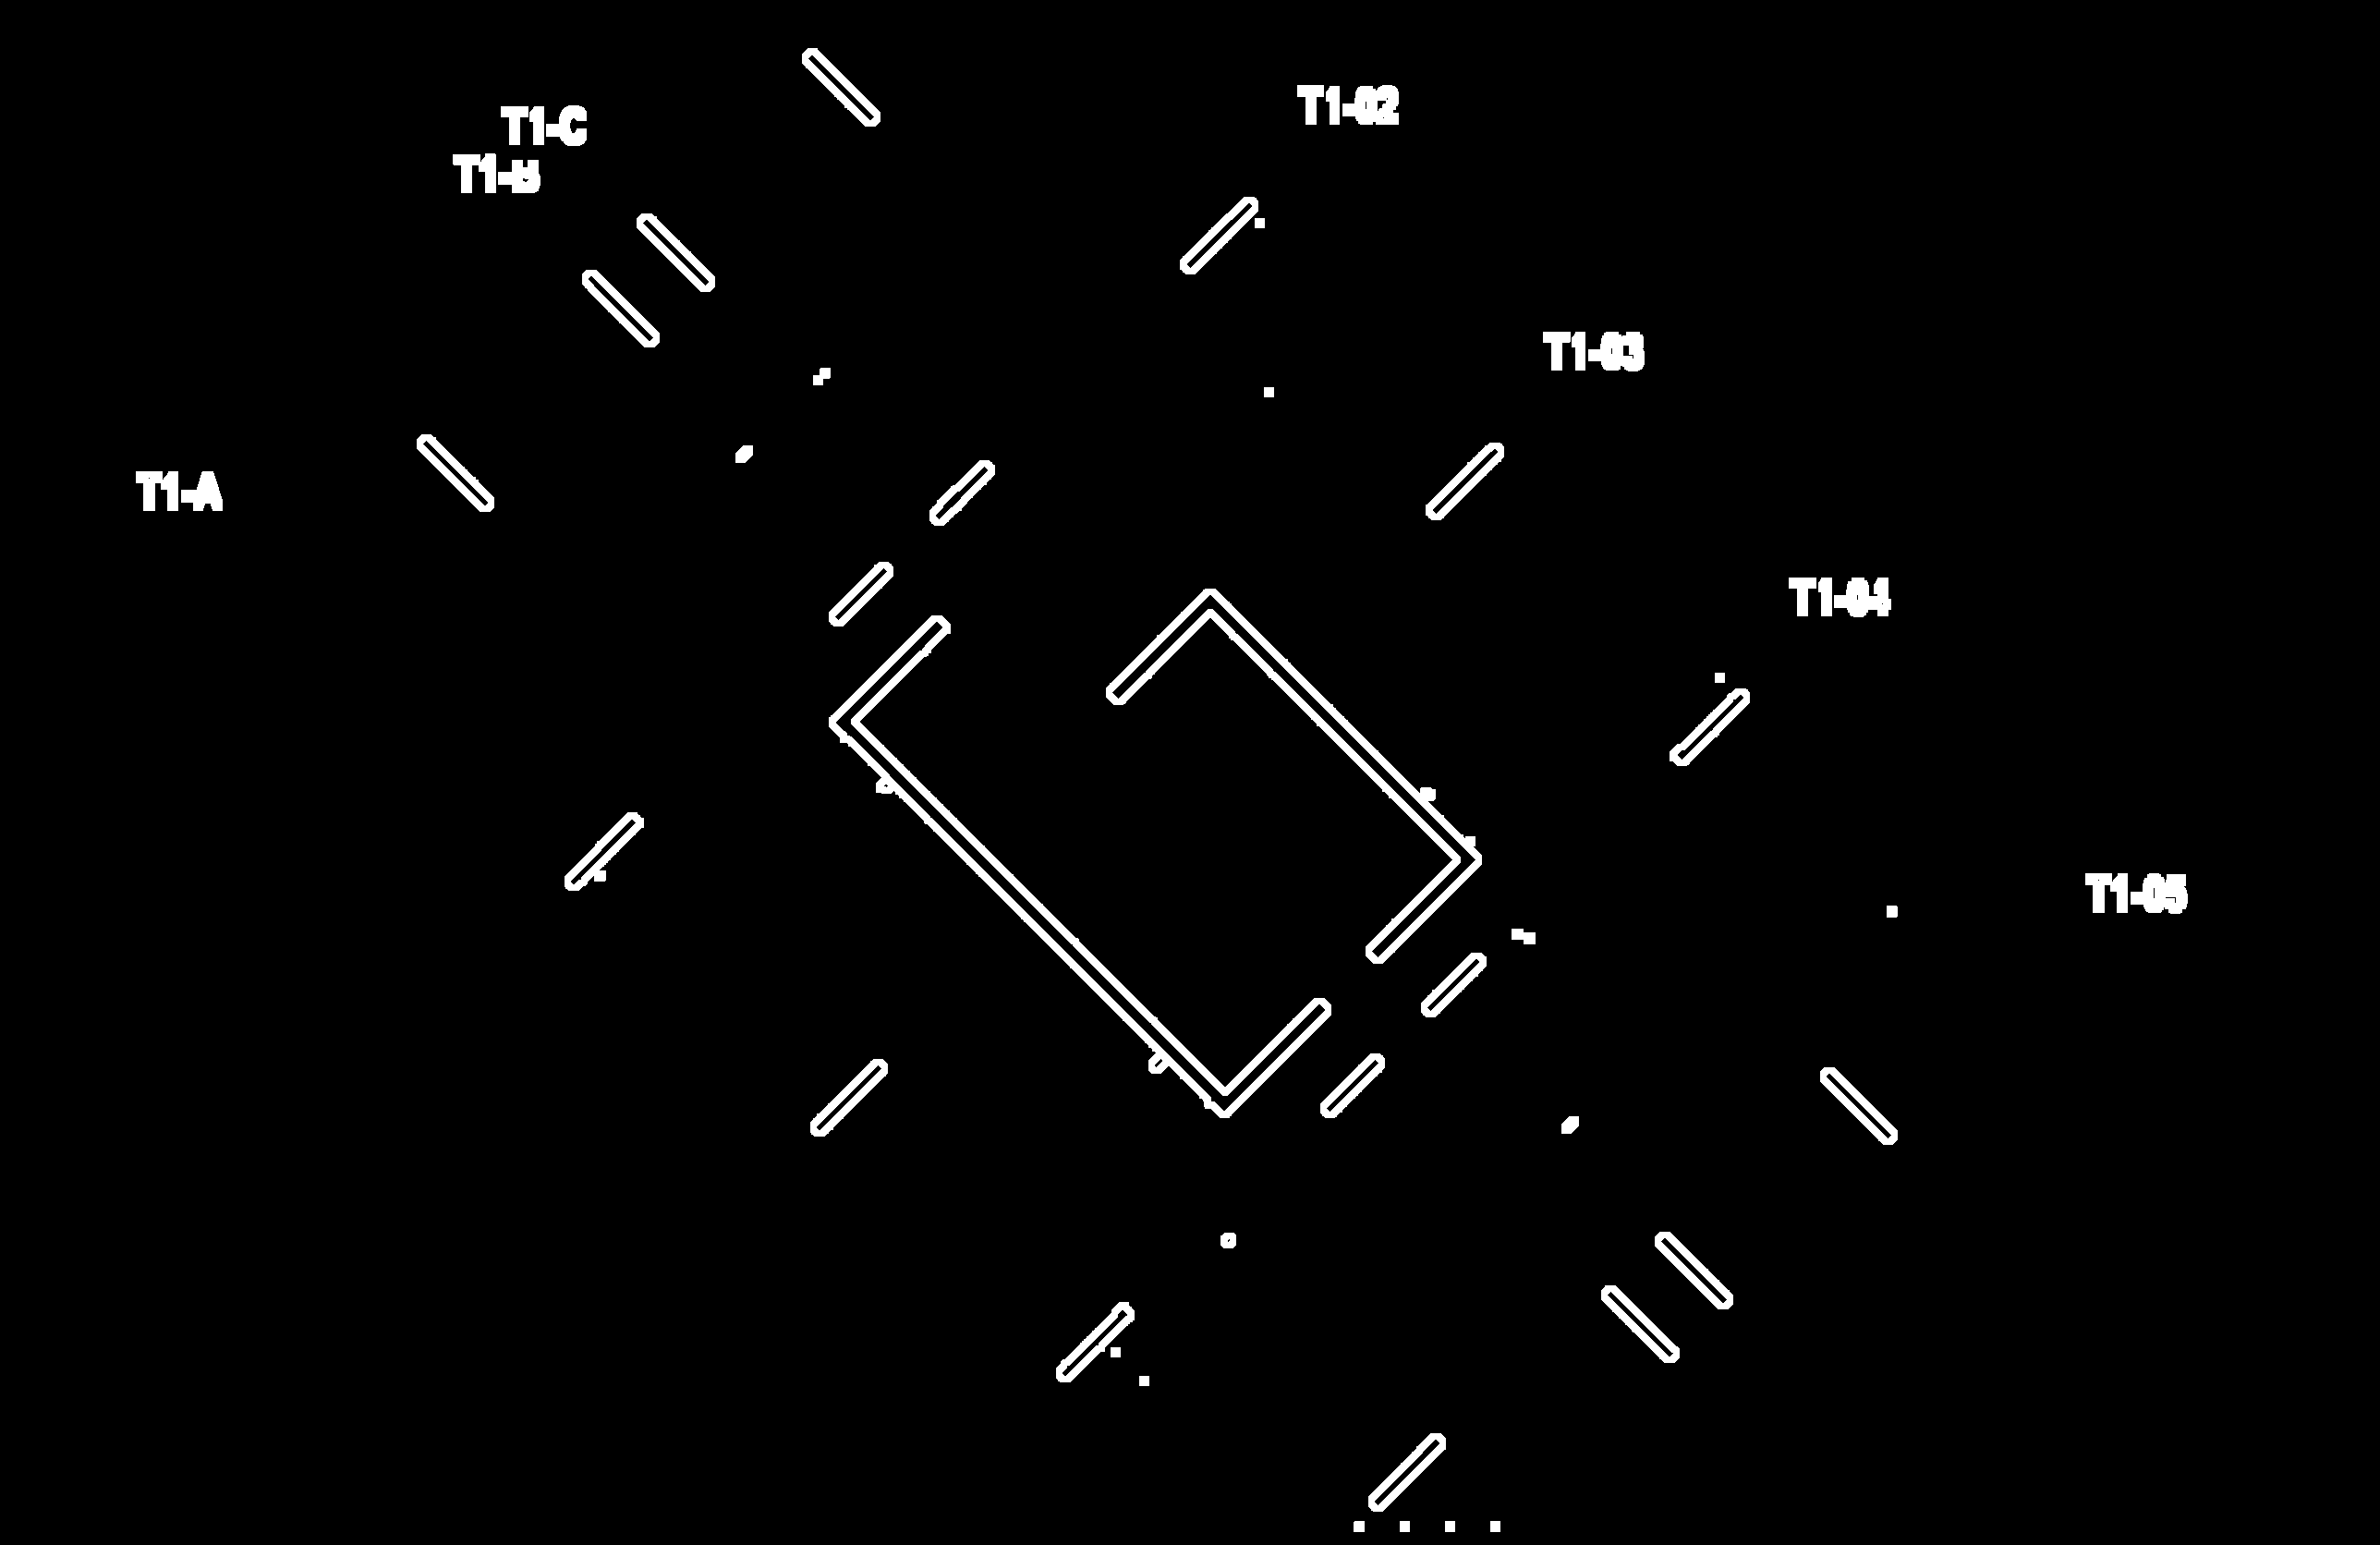

In [20]:
'''
    Generate wall data file for floorplan
    @Param img_path, path to input file
    @Param info, boolean if data should be printed
    @Return shape
    '''
from utils.FloorplanToBlenderLib import *
# Read floorplan image
img = cv2.imread(img_path)

# grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create wall image (filter out small objects from image)
wall_img = detect.wall_filter(gray)

# detect walls
boxes, img = detect.detectPreciseBoxes(wall_img)

display(Image.fromarray(wall_img))

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
wall_height = 1

# Scale pixel value to 3d pos
scale = 100

# Convert boxes to verts and faces
verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

# CubiCasa Pre-Trained Object/Room Segmentation          
# (Deep Neural Network)

In [21]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Import library
from utils.FloorplanToBlenderLib import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
import cv2 
from torch.utils.data import DataLoader

from model import get_model
from utils.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from utils.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
# discrete_cmap()
from utils.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath",
                "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink",
                "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

model = get_model('hg_furukawa_original', 51)
n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()

# Create tensor for pytorch
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # correct color channels

# Image transformation to range (-1,1)
img = 2 * (img / 255.0) - 1

# Move from (h,w,3)--->(3,h,w) as model input dimension is defined like this
img = np.moveaxis(img, -1, 0)

# Convert to pytorch, enable cuda
img = torch.tensor([img.astype(np.float32)]).cuda()
n_rooms = 12
n_icons = 11

with torch.no_grad():
    #Check if shape of image is odd or even
    size_check = np.array([img.shape[2],img.shape[3]])%2

    height = img.shape[2] - size_check[0]
    width = img.shape[3] - size_check[1]

    img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(img, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)


rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

heatmaps, rooms, icons = split_prediction(prediction, img_size, split)

print(heatmaps.shape)
print(rooms.shape)
print(icons.shape)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

wall_polygon_numbers=[i for i,j in enumerate(types) if j['type']=='wall']
boxes=[]
for i,j in enumerate(polygons):
    if i in wall_polygon_numbers:
        temp=[]
        for k in j:
            temp.append(np.array([k]))
        boxes.append(np.array(temp))
        
verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])


/tmp/ipykernel_537954/3344762245.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  img = torch.tensor([img.astype(np.float32)]).cuda()


(21, 1672, 2576)
(12, 1672, 2576)
(11, 1672, 2576)


In [22]:
discrete_cmap()

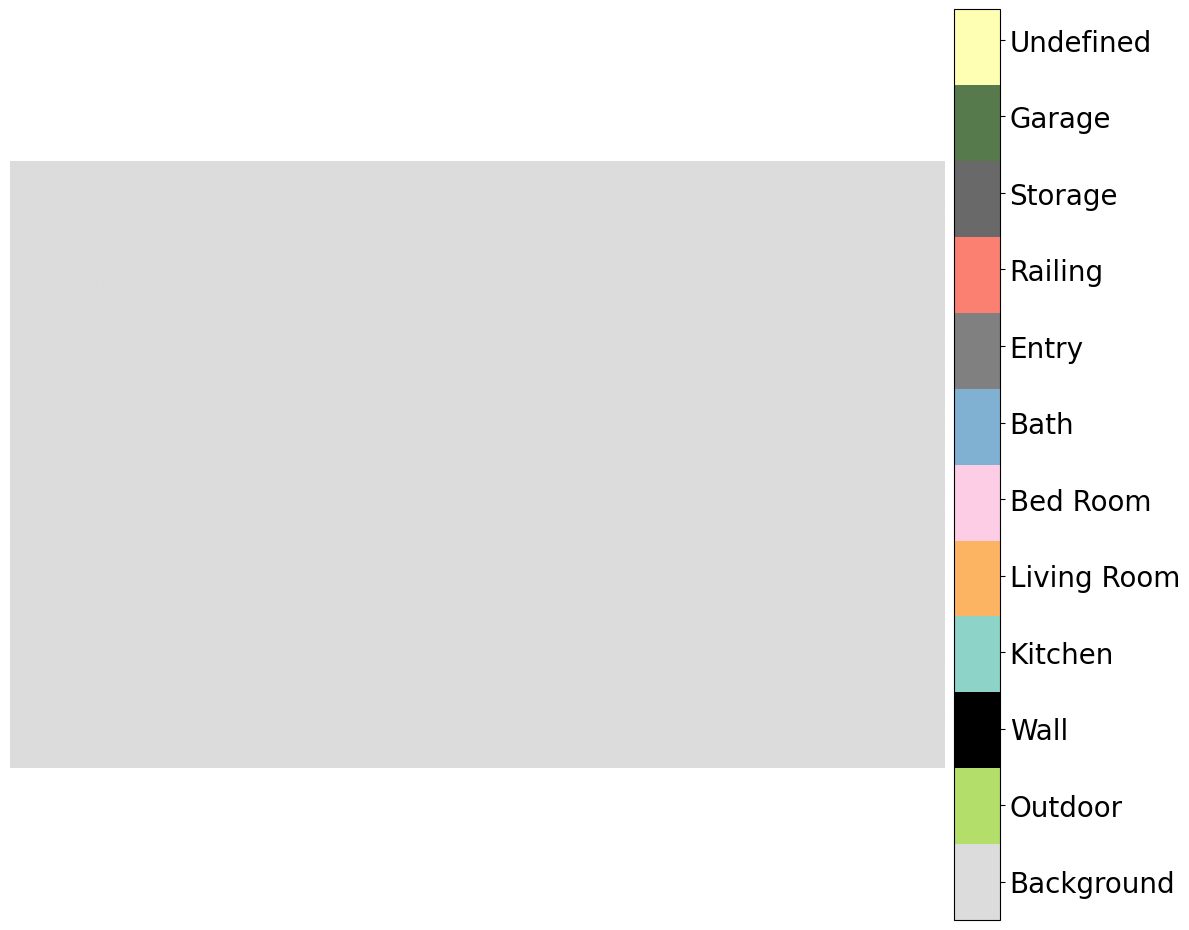

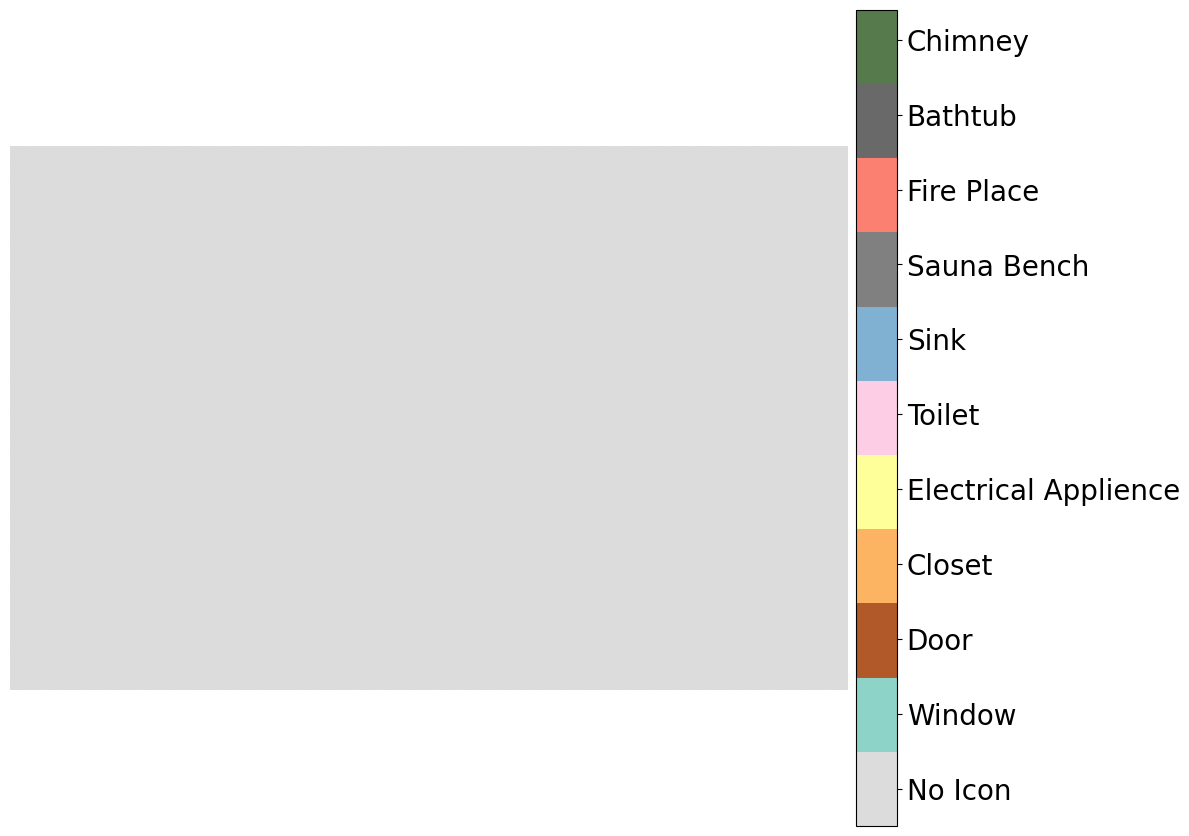

In [23]:
pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()

# Generate data files and Blender files (Using CubiCasa and Super-Resolution)

In [24]:
import FloorplanToSTL as stl
import config

# can specify or use default paths in config files
stl.createFloorPlan(image_path = config.image_path, target_path = config.target_path, SR_Check=True)

# Note: USE SR_Check = False for Original Image 

 ----- Generate  Images/example.png  at pos  None  rot  None  -----
Approximated apartment size :  431494.0
Created file : Data/10/floor_verts.txt
Created file : Data/10/floor_faces.txt
Walls created :  121
Created file : Data/10/wall_verts.txt
Created file : Data/10/wall_faces.txt
Created file : Data/10/top_wall_verts.txt
Created file : Data/10/top_wall_faces.txt
Number of rooms detected :  4
Created file : Data/10/rooms_verts.txt
Created file : Data/10/rooms_faces.txt
Created file : Data/10/transform.txt


Traceback (most recent call last):
  File "/mnt/c/Users/admin/source/repos/agent-proj/000.notebooks/Floor-Plan-Detection/floorplan_to_3dObject_in_blender.py", line 283, in <module>
    main(sys.argv)
  File "/mnt/c/Users/admin/source/repos/agent-proj/000.notebooks/Floor-Plan-Detection/floorplan_to_3dObject_in_blender.py", line 165, in main
    bpy.ops.wm.save_as_mainfile(filepath=program_path + target + ".blend") #"/floorplan"
  File "/mnt/c/Users/admin/source/repos/agent-proj/000.notebooks/Floor-Plan-Detection/2.93.1/2.93/scripts/modules/bpy/ops.py", line 132, in __call__
    ret = _op_call(self.idname_py(), None, kw)
RuntimeError: Error: Cannot open file /mnt/c/Users/admin/source/repos/agent-proj/000.notebooks/Floor-Plan-Detection./floorplan.blend@ for writing: No such file or directory



CalledProcessError: Command '['/mnt/c/Users/admin/source/repos/agent-proj/000.notebooks/Floor-Plan-Detection/2.93.1/blender', '-noaudio', '--background', '--python', '/mnt/c/Users/admin/source/repos/agent-proj/000.notebooks/Floor-Plan-Detection/floorplan_to_3dObject_in_blender.py', '/mnt/c/Users/admin/source/repos/agent-proj/000.notebooks/Floor-Plan-Detection', './floorplan', 'Data/10/']' returned non-zero exit status 1.

In [19]:
from utils.FloorplanToBlenderLib import *
from subprocess import check_output
# import config
import os


def createFloorPlan(image_path, target_path, SR_Check=True):
    # import config 
    SR = [SR_scale, SR_method]
    # program_path = program_path
    # blender_install_path = blender_install_path
    # blender_script_path = blender_script_path
    # CubiCasa = CubiCasa
    data_paths = [execution.simple_single(image_path, CubiCasa, SR)]
  
    check_output([blender_install_path,
     "-noaudio", # this is a dockerfile ubuntu hax fix
     "--background",
     "--python",
     blender_script_path,
     program_path, # Send this as parameter to script
     target_path
     ] +  data_paths)
    
    print("Created File at "+target_path)

In [22]:
import os

image_path = 'Images/fp-3.jpg'
target_path = '/floorplan_3' # will export in two formats (.blend and .stl)
program_path = os.getcwd()  
blender_install_path = program_path+"/2.93.1/blender"
blender_script_path = program_path+"/floorplan_to_3dObject_in_blender.py"

SR_scale = 2
SR_method = 'lapsrn'

CubiCasa = True

In [23]:
createFloorPlan(image_path = image_path, target_path = target_path, SR_Check=True)

 ----- Generate  Images/fp-3.jpg  at pos  None  rot  None  -----
Approximated apartment size :  231847.5
Created file : Data/10/floor_verts.txt
Created file : Data/10/floor_faces.txt
Walls created :  192
Created file : Data/10/wall_verts.txt
Created file : Data/10/wall_faces.txt
Created file : Data/10/top_wall_verts.txt
Created file : Data/10/top_wall_faces.txt
Number of rooms detected :  5
Created file : Data/10/rooms_verts.txt
Created file : Data/10/rooms_faces.txt
Created file : Data/10/transform.txt
Created File at /floorplan_3


In [3]:
# from stl import mesh
# from pythreejs import *
# from IPython.display import display

# # Load the STL file
# your_mesh = mesh.Mesh.from_file('floorplan.stl') # Replace 'your_mesh.stl' with your file path

# # Create geometry from the mesh data
# vertices = BufferAttribute(array=your_mesh.vectors.flatten(), normalized=False) # Ensure correct flattening
# geometry = BufferGeometry( attributes={'position': vertices})

# # Create a material and a mesh object
# material = MeshStandardMaterial(color='white') # You can customize color
# mesh_obj = Mesh(geometry=geometry, material=material)

# # Create a scene and add the mesh
# scene = Scene(children=[mesh_obj, AmbientLight(color='gray')]) # Add AmbientLight for visibility
# camera = PerspectiveCamera(position=(0, 0, 50)) # Adjust camera position as needed
# renderer = Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)])

In [4]:
# # Display the rendered object
# display(renderer)

Renderer(camera=PerspectiveCamera(position=(0.0, 0.0, 50.0), projectionMatrix=(2.1445069205095586, 0.0, 0.0, 0…

In [27]:
# display()

In [28]:
from IPython.display import display, HTML

# This will display
display(HTML("<h1>Hello from display!</h1>"))

In [15]:
# from pythreejs import *
# from IPython.display import display
# import ipywidgets

In [6]:
# # Reduce repo churn for examples with embedded state:
# from pythreejs._example_helper import use_example_model_ids
# use_example_model_ids()

In [12]:
# ball = Mesh(geometry=SphereGeometry(),
#             material=MeshLambertMaterial(color='red'))

# your_mesh = mesh.Mesh.from_file('floorplan.stl') # Replace 'your_mesh.stl' with your file path
# print(your_mesh)

# # Create geometry from the mesh data
# vertices = BufferAttribute(array=your_mesh.vectors.flatten(), normalized=True) # Ensure correct flattening
# geometry = BufferGeometry( attributes={'position': vertices})

# # Create a material and a mesh object
# material = MeshStandardMaterial(color='red') # You can customize color
# mesh_obj = Mesh(geometry=geometry, material=material)

# key_light = DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)

# c = PerspectiveCamera(position=[0, 5, 5], up=[0, 1, 0], children=[key_light])

# scene = Scene(children=[ball, mesh_obj, c, AmbientLight(color='#777777')], background=None)

# renderer = Renderer(camera=c,
#                     scene=scene,
#                     alpha=True,
#                     clearOpacity=0,
#                     controls=[OrbitControls(controlling=c)])
# display(renderer)

<Mesh: b'Exported from Blender-2.93.1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00' 9013 vertices>


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

In [14]:
# from pythreejs import (
#     # Viewer,
#     Mesh,
#     MeshLambertMaterial,
#     STLLoader,
#     AmbientLight,
#     DirectionalLight,
# )
# from pythreejs.widgets import Viewer
# from IPython.display import display

# # Assuming 'your_model.stl' is in the same directory or a specified path
# # You might need a way to serve the file if running in a remote environment
# # For local Jupyter notebooks, direct file paths often work.

# # 1. Load the STL file
# # The STLLoader expects a URL, so for local files, you might need to ensure
# # they are accessible via a local web server or a suitable path.
# # For simplicity, if running in a local Jupyter environment, a direct path might work.
# stl_loader = STLLoader()
# geometry = stl_loader.load("floorplan.stl") # Replace with your STL file path

# # 2. Create a Material
# material = MeshLambertMaterial(color="blue", side="DoubleSide")

# # 3. Create a Mesh
# mesh = Mesh(geometry=geometry, material=material)

# # 4. Create a Viewer and add components
# viewer = Viewer(
#     camera_fov=50,
#     camera_position=[0, 0, 5],
#     width=600,
#     height=400,
#     controls=["orbit"],
# )

# # Add lights for better visibility
# ambient_light = AmbientLight(color="white", intensity=0.5)
# directional_light = DirectionalLight(color="white", position=[1, 1, 1], intensity=0.8)

# viewer.scene.add([mesh, ambient_light, directional_light])

# # Display the viewer
# display(viewer)

In [4]:
# from stl import mesh
# from pythreejs import (
#     Scene, PerspectiveCamera, WebGLRenderer, AmbientLight, DirectionalLight,
#     Mesh, MeshLambertMaterial, Geometry, BufferAttribute
# )
# from IPython.display import display

# # Load your STL file
# mesh_data = mesh.Mesh.from_file('floorplan.stl')

# # Extract vertices and faces
# vertices = mesh_data.vectors.reshape(-1, 3) # Flatten the array of triangles into individual vertices
# # faces = mesh.Mesh(mesh_data).vectors.reshape(-1, 9) # Reshape faces into a flat array of 9 coordinates per face

In [5]:
# geometry = Geometry(
#     attributes={
#         'position': BufferAttribute(array=vertices, normalized=False),
#         # If your STL has normals, you can add them here as well
#     },
#     # For indexed geometry, you would use 'index' here
# )

In [13]:
# # Create a material
# material = MeshLambertMaterial(color='red')

# # Create a mesh
# mesh = Mesh(geometry=geometry, material=material)

# # Create a scene
# scene = Scene(children=[mesh])

# # Add lights
# ambient_light = AmbientLight(intensity=0.5)
# directional_light = DirectionalLight(intensity=0.8)
# directional_light.position = [1, 1, 1]
# scene.add(ambient_light, directional_light)

# # Create a camera
# camera = PerspectiveCamera(position=[5, 5, 5], up=[0, 0, 1],
#                            children=[directional_light])
# scene.add(camera)

# # Create a renderer
# renderer = WebGLRenderer(camera=camera, scene=scene, width=600, height=400)

In [ ]:
display(renderer)

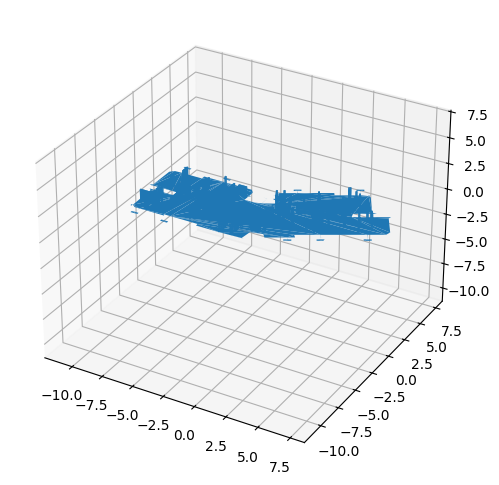

In [12]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

# Create a new plot
figure = pyplot.figure(figsize=(10, 6))
axes = figure.add_subplot(projection='3d')

# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('floorplan.stl')
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))

# Auto scale to the mesh size
scale = your_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
pyplot.show()

In [17]:
import pythreejs as three
import numpy as np
from stl import mesh

# Load the STL file
your_mesh = mesh.Mesh.from_file('floorplan.stl')

# Extract vertices and normals
# numpy-stl provides flattened arrays, so we need to reshape
vertices = your_mesh.vectors.reshape(-1, 3)
normals = your_mesh.normals.repeat(3, axis=0) # Normals are per face, need to repeat for each vertex

# Create BufferGeometry
geometry = three.BufferGeometry(
    attributes={
        'position': three.BufferAttribute(np.array(vertices, dtype=np.float32), normalized=False, itemSize=3),
        'normal': three.BufferAttribute(np.array(normals, dtype=np.float32), normalized=False, itemSize=3)
    }
)

# Create Material
material = three.MeshPhongMaterial(color='gray')

# Create Mesh
mesh_obj = three.Mesh(geometry, material)

# Create Scene, Camera, and Renderer
camera = three.PerspectiveCamera(position=[0, 0, 5], up=[0, 1, 0], fov=60)
camera.lookAt([0, 0, 0])
scene = three.Scene(children=[mesh_obj, three.AmbientLight(color='#dddddd'), three.DirectionalLight(position=[1,1,1])])
renderer = three.Renderer(camera=camera, scene=scene, controls=[three.OrbitControls(controlling=camera)])

# Display the renderer (e.g., in a Jupyter Notebook)
renderer.width = 800  # Set the width to 800 pixels
renderer.height = 600 # Set the height to 600 pixels
renderer

Renderer(camera=PerspectiveCamera(fov=60.0, position=(0.0, 0.0, 5.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.…

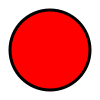

In [2]:
from IPython.display import SVG

# Display from a file path
# SVG(filename='path/to/your/image.svg')

# Display from raw SVG markup
svg_markup = """
<svg width="100" height="100">
  <circle cx="50" cy="50" r="40" stroke="black" stroke-width="3" fill="red" />
</svg>
"""
SVG(svg_markup)